In [312]:
import numpy as np
import probnum as pn
from probnum.randprocs.covfuncs import Matern
import matplotlib.pyplot as plt
from scipy.linalg import circulant

Set $\mathcal{X} = L^1(G)$, $\mathcal{Y} = L^2(G)$ with $G$ the one dimensional torus. 
Our goal is to learn the function $w^\ast  \in  \mathcal{Y} $  given the convolution operators $(\Phi_{x_i})_{i=1}^n$, where we have that 
$$
 y_i= \Phi_{x_i} w^\ast  +\epsilon_i \quad i=1, \dots, N,
 $$

 $x_i \in \mathcal{X} $ and $y_i \in  \mathcal{Y} $.



To recover $w^\ast$  we consider  the regularized KRR estimator

$$
\hat{w}_\lambda =\arg\min_{w\in \mathcal{H}} \frac 1 N \sum_{i=1}^N \left\lVert X_i  w - y_i\right\lVert_{\mathcal{Y} }^2+\lambda \left\lVert w \right\lVert_\mathcal{H}^2, \quad \quad \lambda>0 
$$

where $\mathcal{H} \subset \mathbb{R}^d$ is RKHS, and implement
$$
\hat{w}_\lambda = S^\ast ( S S^\ast + \lambda I) ^{-1} Y
$$

where $S$ is the sampling operator.

In the discretazed case, and in the following computations,
 $X_i : = \Phi_{x_i} \in \mathbb{R}^{d\times d}$ are circulant matrices representing discrete circular convolution operators with the vector $x_i$ and $Y = [y_1, \dots,y_N]$.

In [313]:

# Define the functions needed for inference

def S_star_operator(Y, X ,ker_mat, t_right, t_left, N, d):
    
    S_star = ker_mat.T @ sum(X[i].T @ Y[:,i] for i in range(N)) *( (t_right-t_left)/(N*d) )
    
    return S_star


def S_S_star_matrix(Y, X ,ker_mat, t_right, t_left, N, d):
    
    # this is a tensor reshaped in the appropriate form to be able to compute the inverse in the inference 
    
    SS_star_tensor = np.zeros((N,N,d,d))
    
    for i in range(0,N):
        for j in range(0,N):
            SS_star_tensor[i,j,:,:] = X[i] @ ker_mat @ X[j].T
            
    SS_star_mat = SS_star_tensor.swapaxes(1,2).reshape(d*N,d*N) *( (t_right-t_left)/(N*d) )
    
    return SS_star_mat 

def Kronecker_mat_regul(lam,N,d):

    Sigma_Kron = pn.linops.Kronecker(
        A = (lam) * np.eye(N,N),
        B = np.eye(d,d)
        )    # (dF x dF)
    return Sigma_Kron


def S_star_operator_for_cov(XK, X, k, N, h ):

    S_star =   sum(k @ X[i].T @ XK[i,:,:] for i in range(N)) * (h / N)
    
    return S_star

def Kronecker_mat_regul(lam,N,d):

    Sigma_Kron = pn.linops.Kronecker(
        A = (lam) * np.eye(N,N),
        B = np.eye(d,d)
        )    # (dF x dF)
    return Sigma_Kron


def S_star_operator_for_cov(XK, X, k, N, h ):

    S_star =   sum(k @ X[i].T @ XK[i,:,:] for i in range(N)) * (h / N)
    
    return S_star

In [314]:
#CHOOSE number of input functions
N = 15

d = 300 # grid points

t_left = 0
t_right = 1
t = np.linspace(t_left,t_right,d)

__Ground truth__ We choose a ground truth of the form 

$$ w^\ast (t) = \sum_{j=0}^{M}  \frac{\exp\{2 \pi i j t \}}{j^\beta} $$

In [315]:
# Ground truth function
# def sin_polinom(t,alpha,M):
#     return sum((np.sin(2*np.pi*j*t) / (j**alpha)) for j in range(1,M+1))

# def fourier_expon(t,alpha,M):
#     return sum((np.exp(1j*2*k*np.pi*t) / (k**alpha)) for k in range(1,M+2)) + sum((np.exp(1j*2*k*np.pi*t) / (k**alpha)) for k in range(-M,0))

def sin_polin(t,alpha,M):
    return sum((np.sin(2*j*np.pi*t) / (j**alpha)) for j in range(1,M+2))



#CHOOSE ground truth function and obs. noise         y_i = x_i * true_w + noise
beta = .3
sum_until = 20  # index of truncation of the fourier series
true_w = sin_polin(t,beta,sum_until)                        

noise = 0.05

/tmp/ipykernel_3103/712286256.py:14: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


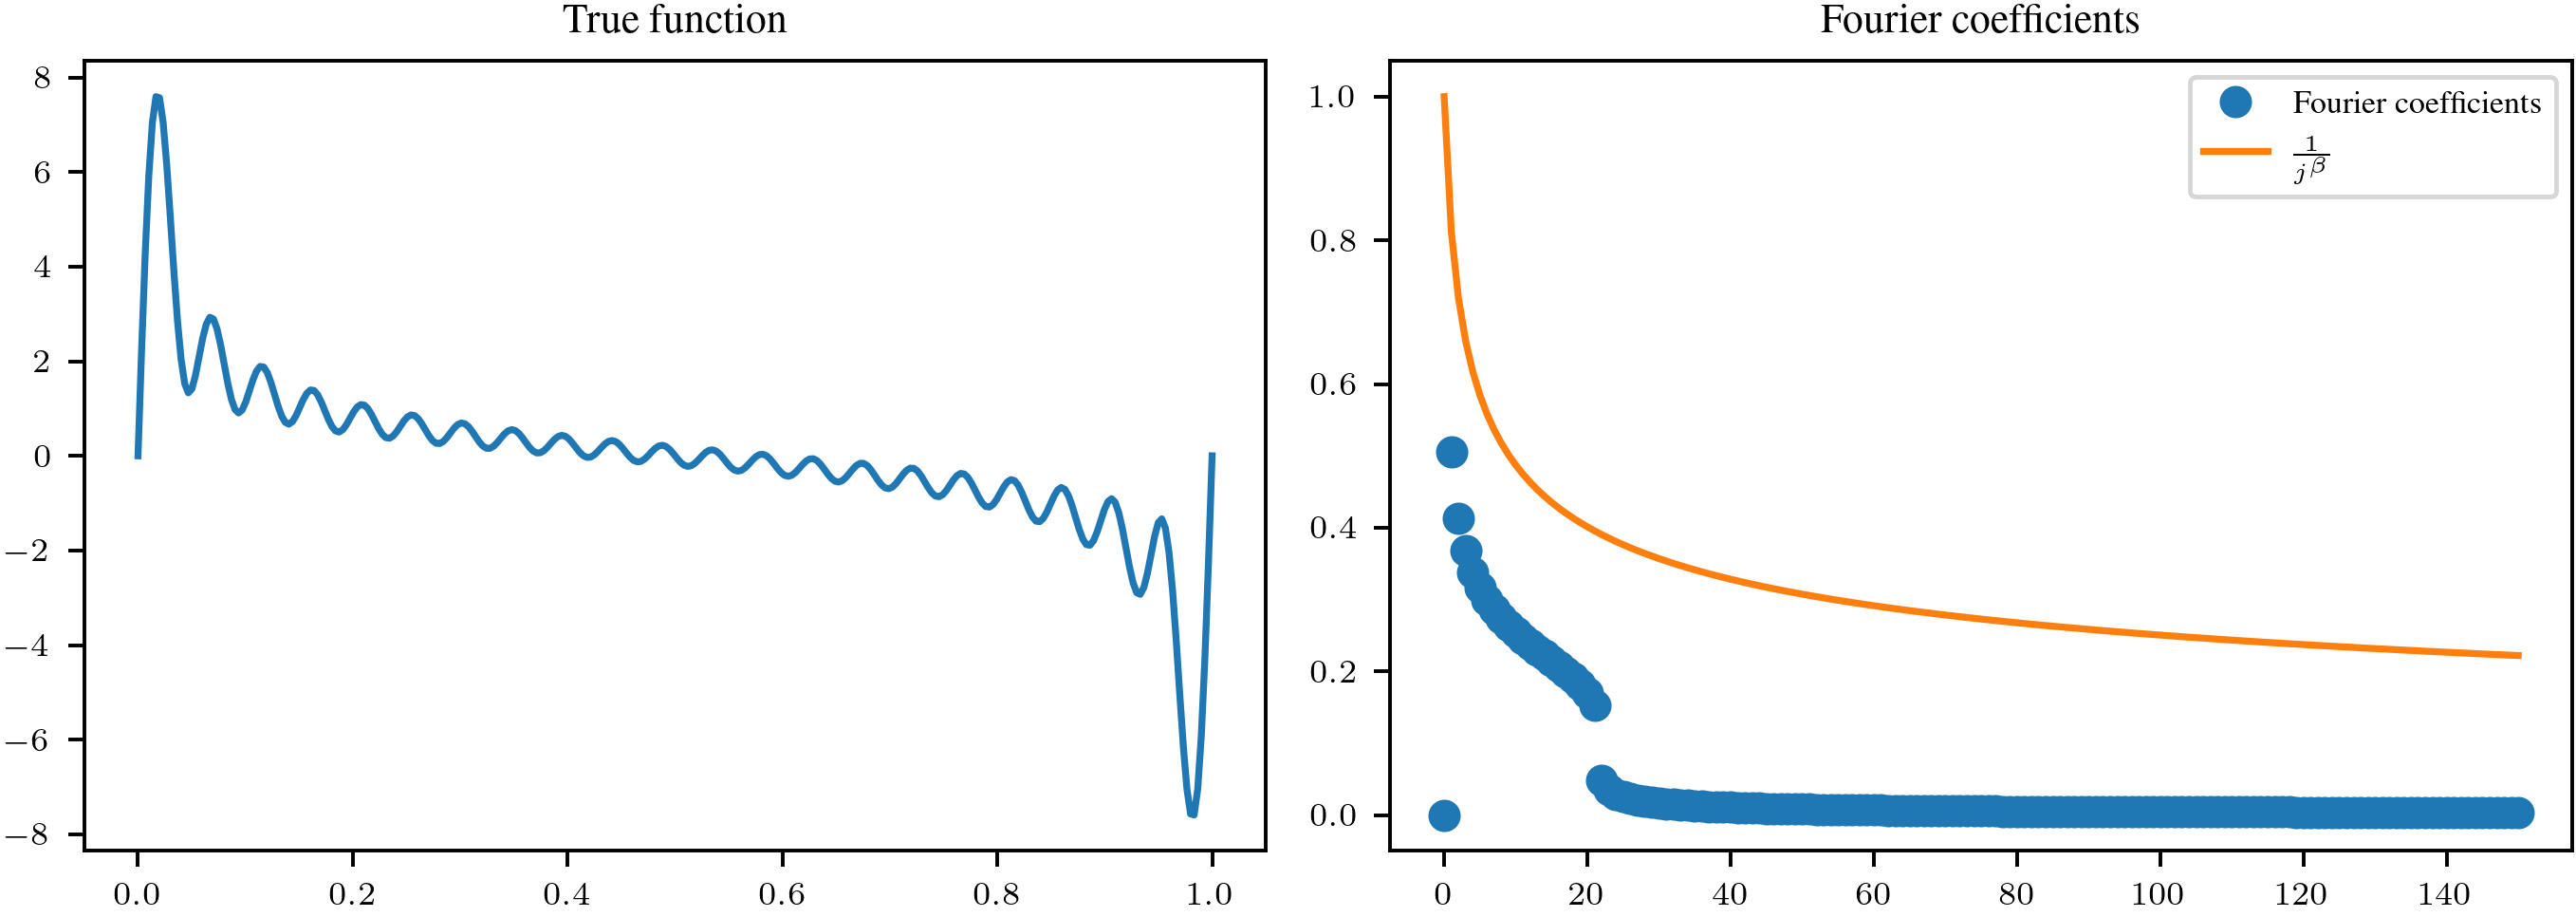

In [316]:
#fourier coefficients of w_true
c = np.fft.rfft(true_w)  / t.size  # normalized by the number of grid points


#plot the true function and its fourier coefficients in two subplots
fig,(ax1, ax2)  = plt.subplots(1,2,figsize=(8, 3))
ax1.plot(t,true_w)
ax1.set_title('True function')
ax2.plot(np.abs(c), 'o', label='Fourier coefficients')
aux_vec=np.arange(1,c.size+1)
ax2.plot(aux_vec**(-beta), label=r'$\frac{1}{j^\beta}$')
ax2.set_title('Fourier coefficients')
ax2.legend()
plt.tight_layout()



Inputs: we will consider two cases. 

1. __Frequency localized signals__: 
    $(x_i)_{i=1}^N$ are i.i.d. samples from the random variable 
    $$X(t) = e^{2 \pi i L t} =  \cos(2 \pi L t) + i \sin(2 \pi L t) $$
    where $L$ is a $ \rho $-distributed random variable on $\mathbb{Z}$. 
    In frequency domain we have that $\widehat{X}_l = \delta(l-L) $.
    
    We will choose a power law distribution $\rho_l = l^{-\beta}$ for $l \in [1, ...,L_{max}+1]$.



2. __Time localized signals__: 
    $(x_i)_{i=1}^N$ are i.i.d. samples from the random variable 
    $$ X(t) = \frac{1}{2\delta}{1}_{[0,2 \delta]} (t-T) $$
    with $T$ random variable on $G$ and $\delta>0$.
    In frequency domain we have that $\widehat{X}_l = e^{-2 \pi i l (T+ \delta)} \text{sinc} ({ 2 \pi \delta l } ) $.

     We will choose $T \sim \mathcal{N}(\mu,\sigma^2)$.
    


In [317]:
#To draw samples from the distribution rho_l = l^-beta

def power_law_samples(N, L, alpha):
    """
    Generates N samples drawn from a power law probability distribution on the integers
    with exponent alpha.
    
    Args:
    - N: an integer specifying the number of samples to generate
    -L: the samples are drawn in the interval [1,L+1]
    - alpha: a positive float specifying the exponent of the power law
    
    Returns:
    - A numpy array of N integers drawn from the power law distribution
    """
    # Define the power law probability density function
    def p(x):
        return 1.0 / (x**alpha)
    
    # Define the normalization constant
    Z = sum([p(l) for l in range(1, L+1)])
    
    # Generate the samples
    samples = []
    while len(samples) < N:
        # Choose a random integer in the range [1, L+1] with probability proportional to p(l)
        n = np.random.choice(range(1, L+1), p=[p(l)/Z for l in range(1, L+1)])
        samples.append(n)
    
    return np.array(samples)

If you choose Case 1 uncomment the following cell:

In [318]:
### Case 1. Inputs localized in frequency

#random vector for frequencies
L_max = sum_until
samples_decay = .8
L = power_law_samples(N, L_max, samples_decay)

#Inputs X = [x_1, .., x_N]
X =  np.array([ np.cos(l*t*2*np.pi) + 1j*np.sin(l*t*2*np.pi)  for l in L]).T

In [319]:
### Case 2. Inputs localized in time

#Gaussian vector 
# T = np.random.normal(.5,.2,N)

#Inputs X = [x_1, .., x_N]
#delta = 0.076
# X = np.array([np.where(((t-l) <= 2*delta) & ((t-l)>=0), 1, 0) for l in T]).T / (2*delta)

If you choose Case 2 uncomment the following cell:

In [320]:
# Make operators (circulant matrices) from the inputs

X_operators = np.zeros((N,d,d))    # Input operators
for i in range(0,N):
    X_operators[i,:,:] =circulant(X[:,i])   



#Output data matrix 
Y = np.zeros((d,N))   #noisy 
for i in range(0,N):
    Y[:,i] = np.real(np.fft.ifft(np.fft.fft(true_w)*np.fft.fft(X[:,i]))) +  noise  * np.random.normal(0,1,d) 


/tmp/ipykernel_3103/1132451479.py:5: ComplexWarning: Casting complex values to real discards the imaginary part
  X_operators[i,:,:] =circulant(X[:,i])


In [321]:

#Caluclate alpha from source conditions

# alpha = .7 * (beta / samples_decay)


__The kernel on the torus__ 



In [322]:
#kernel
def Dirichlet(t,s,p):
    return (2*p + 1)* ( np.sinc( (2*p + 1) * (t-s)  ) / np.sinc(t-s) )


def kernel_fun(f):
    return lambda a, b: np.array(
        [[np.float64(f(a[i], b[j])) for j in range(b.size)]
         for i in range(a.size)]
    )

p = sum_until

k = kernel_fun(lambda a, b: Dirichlet(a,b,p))
k0 = k(t[:,None], t[:,None])

m = np.zeros((len(t),))

/tmp/ipykernel_3103/1722745002.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  [[np.float64(f(a[i], b[j])) for j in range(b.size)]


In [323]:

lamb =  1e-4 #* (N**(-(alpha+2)**(-1)) )
SS_star_mat = S_S_star_matrix(Y = Y, X = X_operators, ker_mat = k0, t_right = t_right, t_left = t_left, N = N, d = d)
lam_kron_mat = Kronecker_mat_regul(lam = lamb, N=N, d=d)
# Inference  
G = SS_star_mat + lam_kron_mat
GY = G.inv() @ Y.T.reshape(d*N,) #np.linalg.solve(G, Y.T.reshape(d*N,))   
GY = GY.reshape(N,d).T
w = S_star_operator(GY, X = X_operators, ker_mat = k0, t_right = t_right, t_left = t_left, N = N, d = d)


    
   

/tmp/ipykernel_3103/3222175933.py:3: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


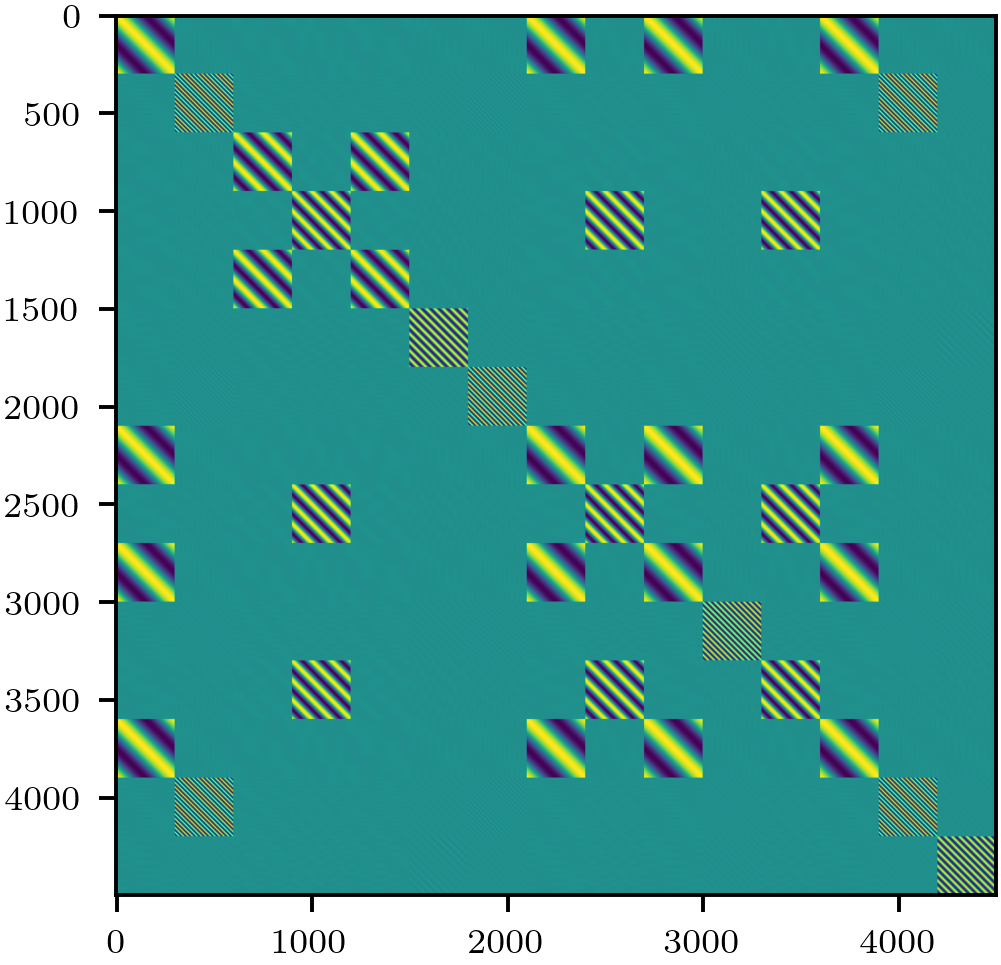

In [333]:
fig, ax = plt.subplots(1,1,figsize=(4, 3))
ax.imshow(SS_star_mat)
plt.tight_layout()

In [324]:
def Dirichlet_fun(t,p):
    return (2*p + 1)* ( np.sinc( (2*p + 1) * (t)  ) / np.sinc(t) )

# ker_coeff = c = np.fft.rfft(Dirichlet_fun(t,p=p))  / t.size

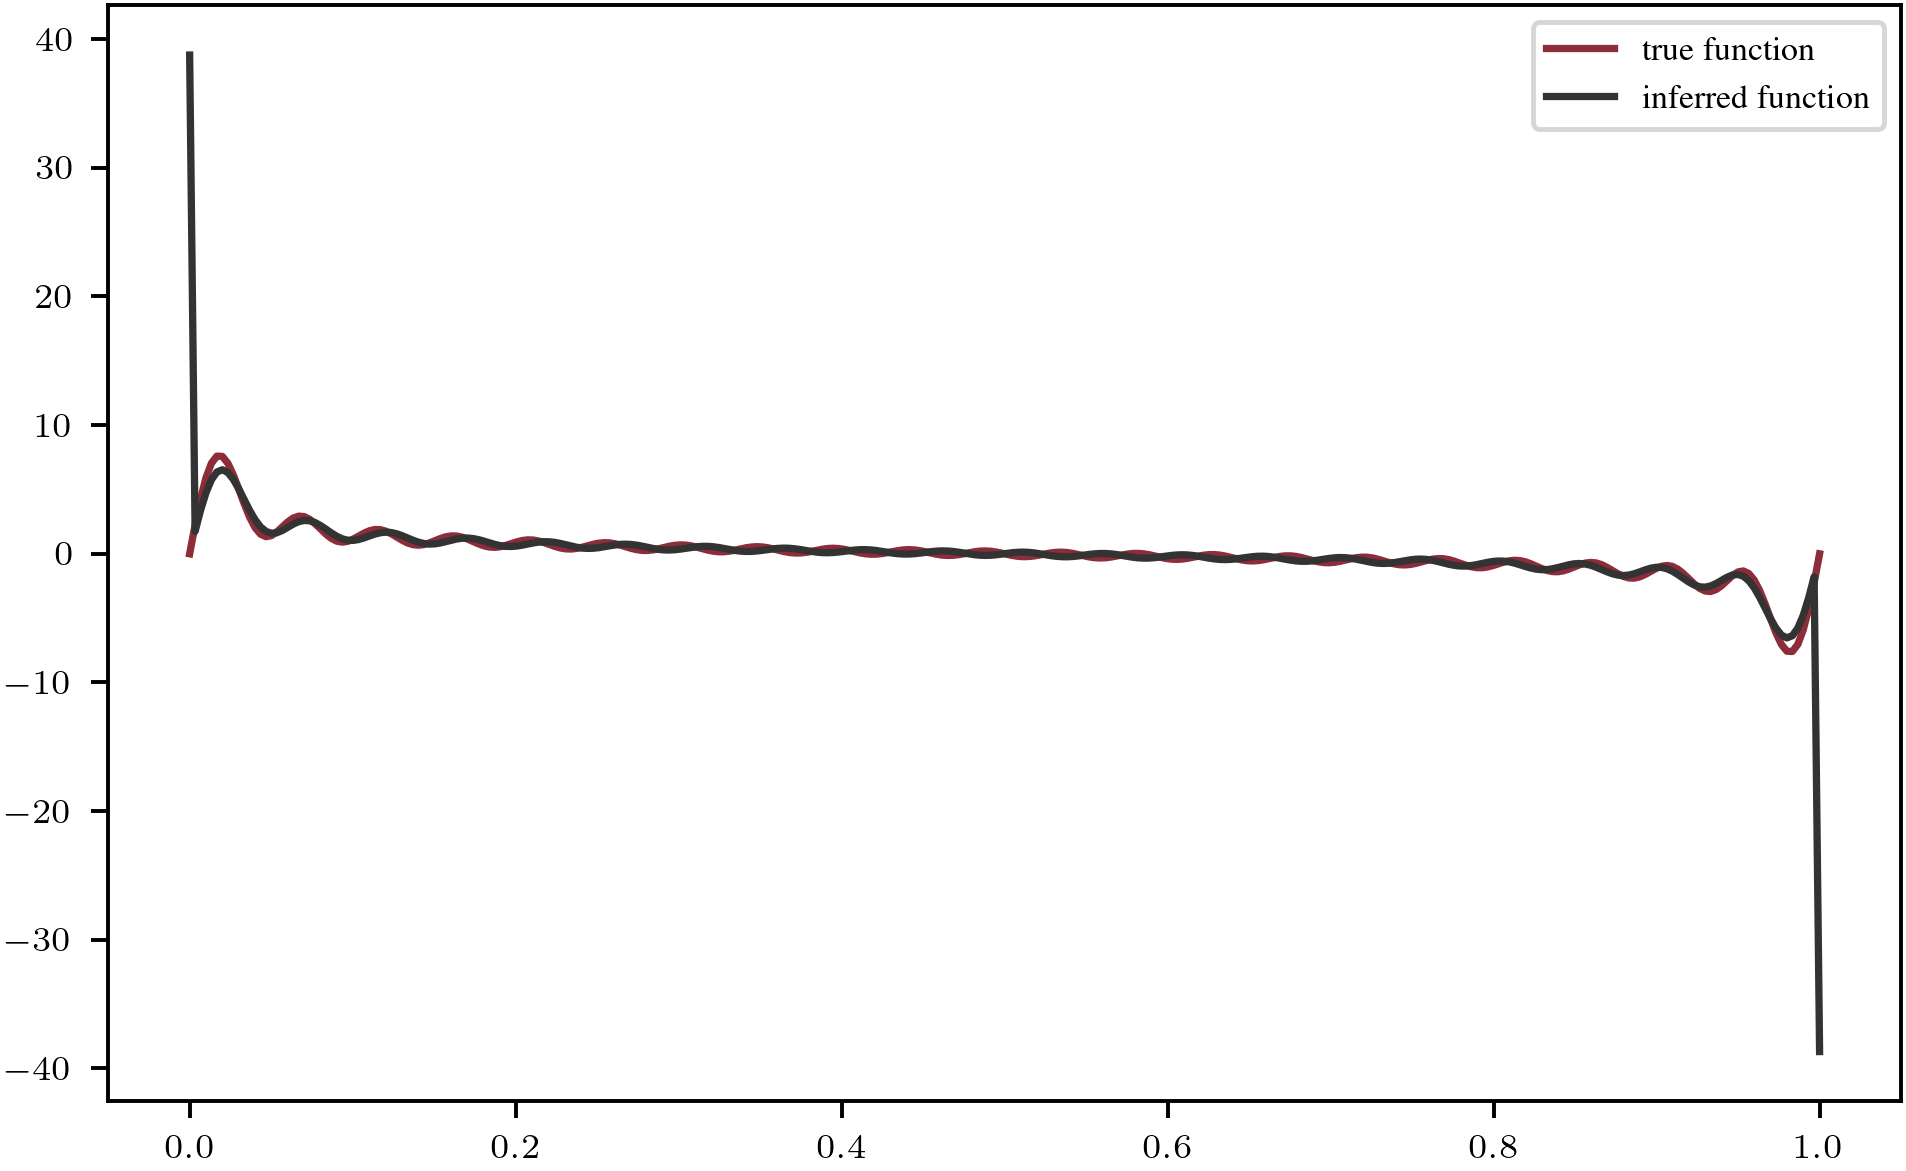

In [325]:
#plotting
from tueplots import  bundles
plt.rcParams.update(bundles.neurips2023())

fig, ax = plt.subplots(1, )
plt.rcParams.update({"figure.dpi": 350})
#define colors
red = np.array([141.0, 45.0, 57.0]) / 255.0
dark = np.array([51.0, 51.0, 51.0]) / 255.0

ax.plot(t, true_w, label="true function", color=red)

ax.plot(t, w, label="inferred function", color=dark)
ax.legend()

